In [38]:
#setup

import pandas as pd # pyright: ignore[reportMissingModuleSource]
import numpy as np # pyright: ignore[reportMissingImports]
import matplotlib.pyplot as plt # pyright: ignore[reportMissingModuleSource]
import seaborn as sns # pyright: ignore[reportMissingModuleSource]
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer # pyright: ignore[reportMissingModuleSource]
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # pyright: ignore[reportMissingModuleSource]
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.model_selection import train_test_split # pyright: ignore[reportMissingModuleSource]
from sklearn.decomposition import PCA # pyright: ignore[reportMissingModuleSource]
from sklearn.cluster import KMeans # pyright: ignore[reportMissingModuleSource]
from scipy.stats import ttest_ind, f_oneway, pearsonr # pyright: ignore[reportMissingImports]
import math

In [39]:
fp = "dataset.csv"
df = pd.read_csv(fp)

In [40]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


In [42]:
df.shape

(18368, 12)

In [43]:
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

In [44]:
df.columns.tolist()

['ID',
 'SystemCodeNumber',
 'Capacity',
 'Latitude',
 'Longitude',
 'Occupancy',
 'VehicleType',
 'TrafficConditionNearby',
 'QueueLength',
 'IsSpecialDay',
 'LastUpdatedDate',
 'LastUpdatedTime']

In [45]:
#data_cleaning
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = ['VehicleType', 'TrafficConditionNearby']
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna('Unknown').astype(str)
print(num_cols)
print(cat_cols)
missing = df.isna().sum().sort_values(ascending=False)
print(missing)



['ID', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'QueueLength', 'IsSpecialDay']
['VehicleType', 'TrafficConditionNearby']
ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
LastUpdatedDate           0
LastUpdatedTime           0
dtype: int64


In [46]:
# Convert LastUpdatedDate and LastUpdatedTime into a proper datetime
df['LastUpdatedTimestamp'] = pd.to_datetime(
    df['LastUpdatedDate'].astype(str) + " " + df['LastUpdatedTime'].astype(str),
    format='%d-%m-%Y %H:%M:%S',
    errors='coerce'
)


print(df['LastUpdatedTimestamp'].isna().sum(), "missing LastUpdatedTimestamp after reconstruction")
df.head(10)

0 missing LastUpdatedTimestamp after reconstruction


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,LastUpdatedTimestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00,2016-10-04 08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00,2016-10-04 09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00,2016-10-04 09:59:00
5,5,BHMBCCMKT01,577,26.144536,91.736172,177,car,low,3,0,04-10-2016,10:26:00,2016-10-04 10:26:00
6,6,BHMBCCMKT01,577,26.144536,91.736172,219,truck,high,6,0,04-10-2016,10:59:00,2016-10-04 10:59:00
7,7,BHMBCCMKT01,577,26.144536,91.736172,247,car,average,5,0,04-10-2016,11:25:00,2016-10-04 11:25:00
8,8,BHMBCCMKT01,577,26.144536,91.736172,259,cycle,average,5,0,04-10-2016,11:59:00,2016-10-04 11:59:00
9,9,BHMBCCMKT01,577,26.144536,91.736172,266,bike,high,8,0,04-10-2016,12:29:00,2016-10-04 12:29:00


In [47]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)
if dup_count>0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates. New shape:", df.shape)

Duplicate rows: 0


In [48]:
df['occupancy_over_capacity_flag'] = (df['Occupancy'] > df['Capacity']).astype(int)


In [49]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric = [c for c in df.columns if c not in numeric_cols]
print("Numeric columns:", numeric_cols)
print("Other columns:", non_numeric)

Numeric columns: ['ID', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'QueueLength', 'IsSpecialDay', 'occupancy_over_capacity_flag']
Other columns: ['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby', 'LastUpdatedDate', 'LastUpdatedTime', 'LastUpdatedTimestamp']


Numeric Columns: ['ID', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'QueueLength', 'IsSpecialDay', 'occupancy_over_capacity_flag', 'TrafficLevel', 'VehicleWeight', 'OccupancyRate', 'QueueNorm', 'Price', 'DemandScore', 'DemandNorm', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
ID: Removed 0 outliers
Capacity: Removed 0 outliers
Latitude: Removed 1312 outliers
Longitude: Removed 0 outliers
Occupancy: Removed 816 outliers
QueueLength: Removed 56 outliers
IsSpecialDay: Removed 2502 outliers
occupancy_over_capacity_flag: Removed 196 outliers
TrafficLevel: Removed 0 outliers
VehicleWeight: Removed 0 outliers
OccupancyRate: Removed 0 outliers
QueueNorm: Removed 0 outliers
Price: Removed 3 outliers
DemandScore: Removed 0 outliers
DemandNorm: Removed 0 outliers
PC1: Removed 0 outliers
PC2: Removed 5 outliers
PC3: Removed 0 outliers
PC4: Removed 0 outliers
PC5: Removed 3 outliers
PC6: Removed 0 outliers
PC7: Removed 0 outliers

Original shape: (18368, 30)
Cleaned shape: (13475, 30)


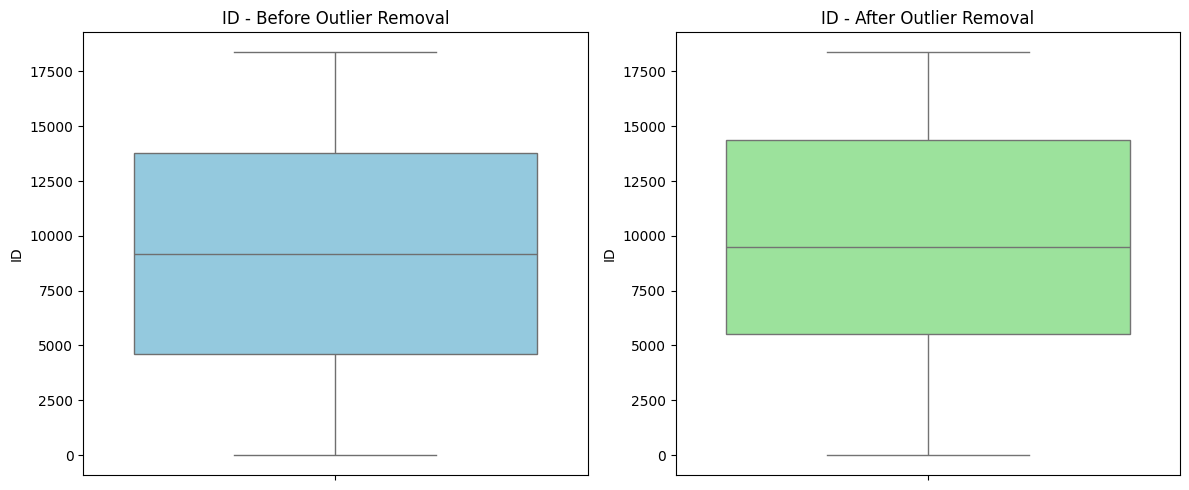

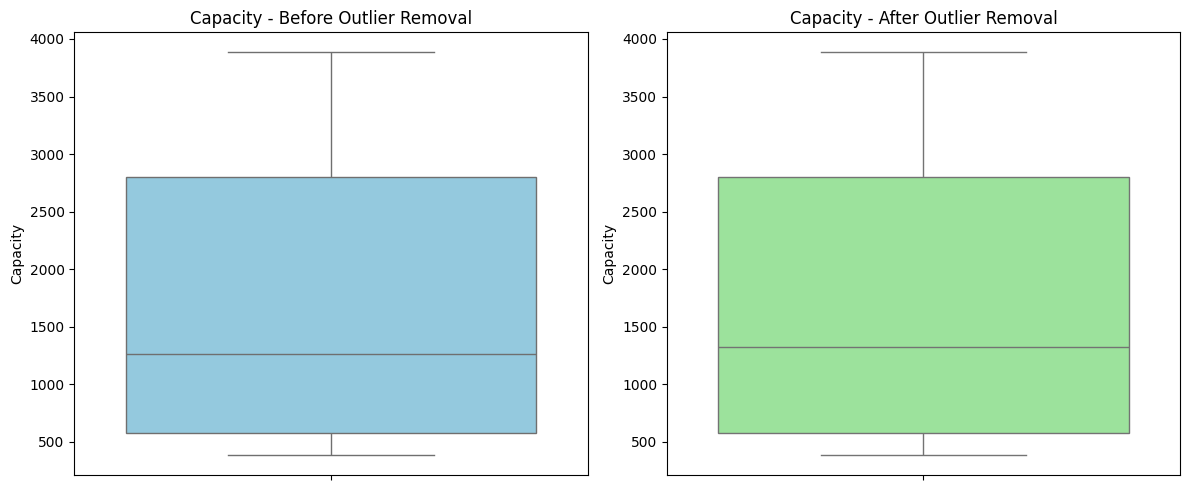

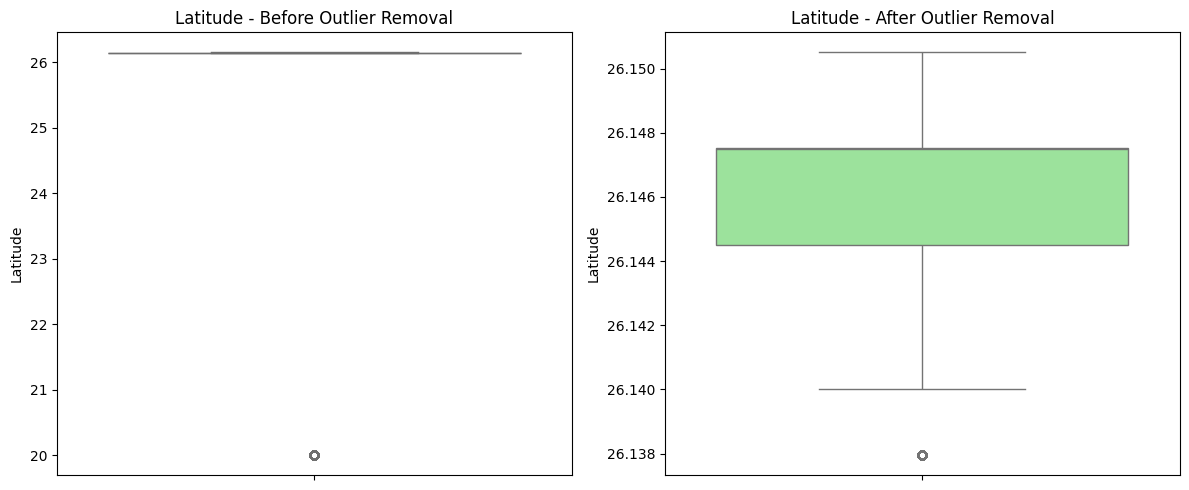

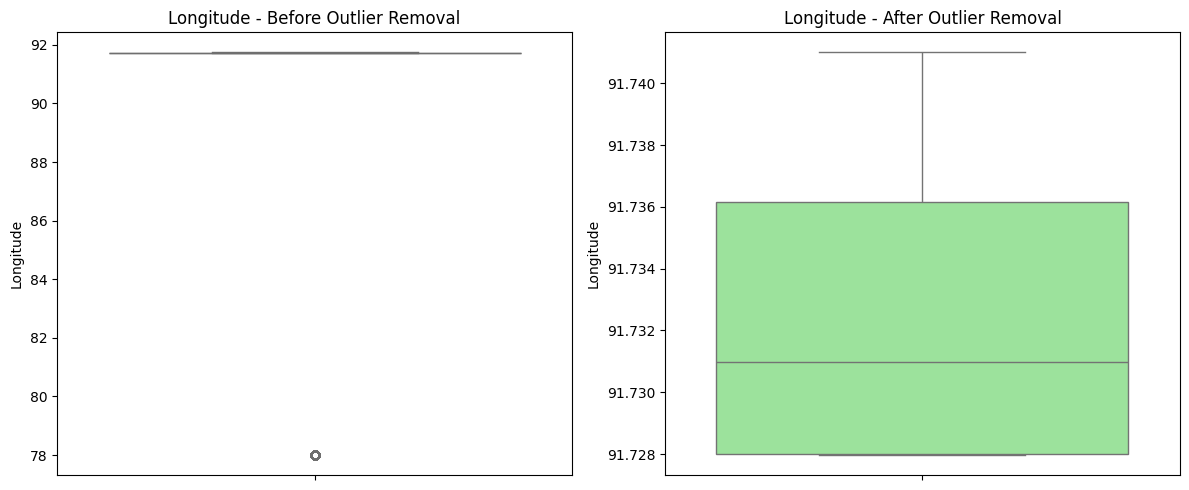

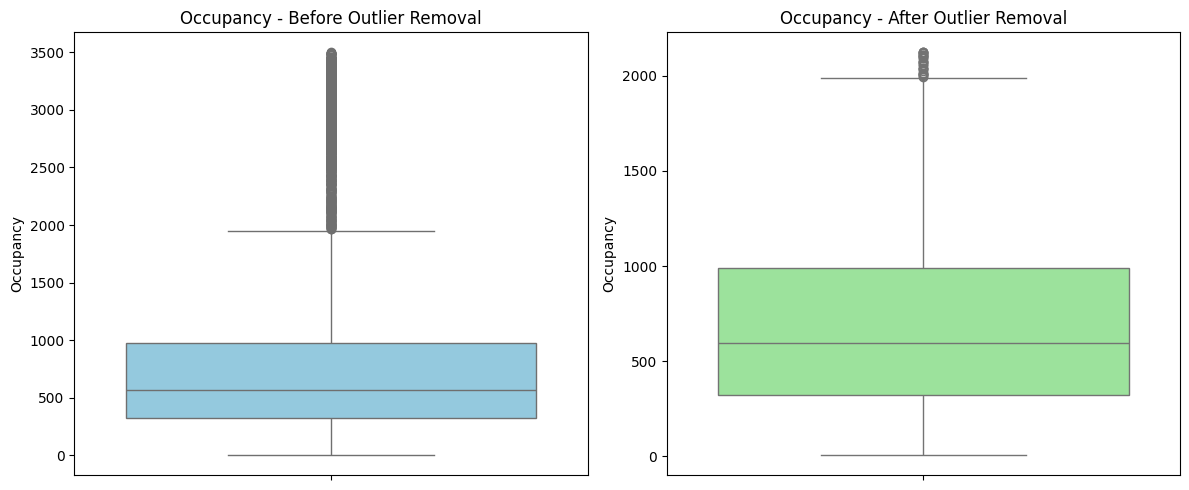

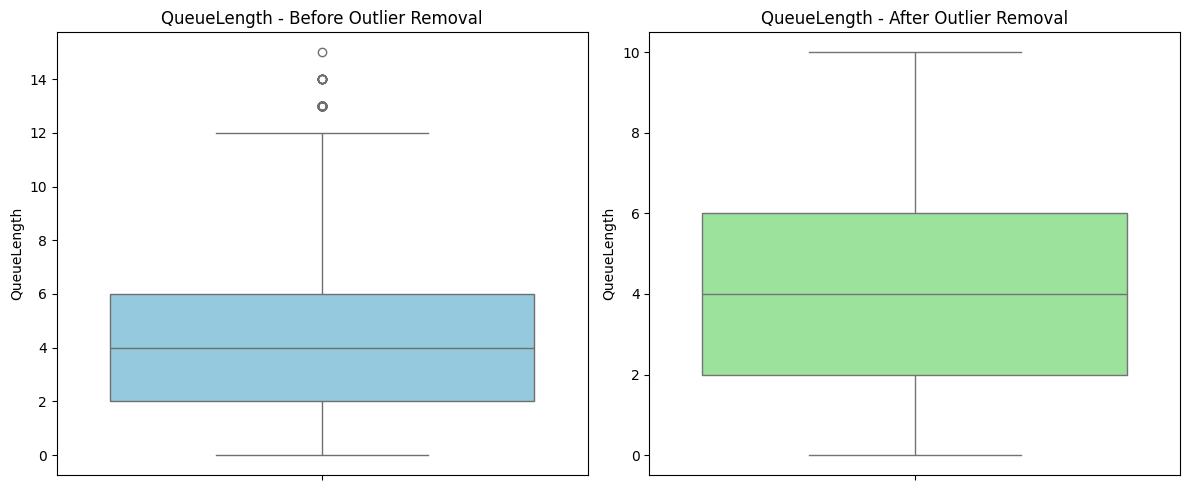

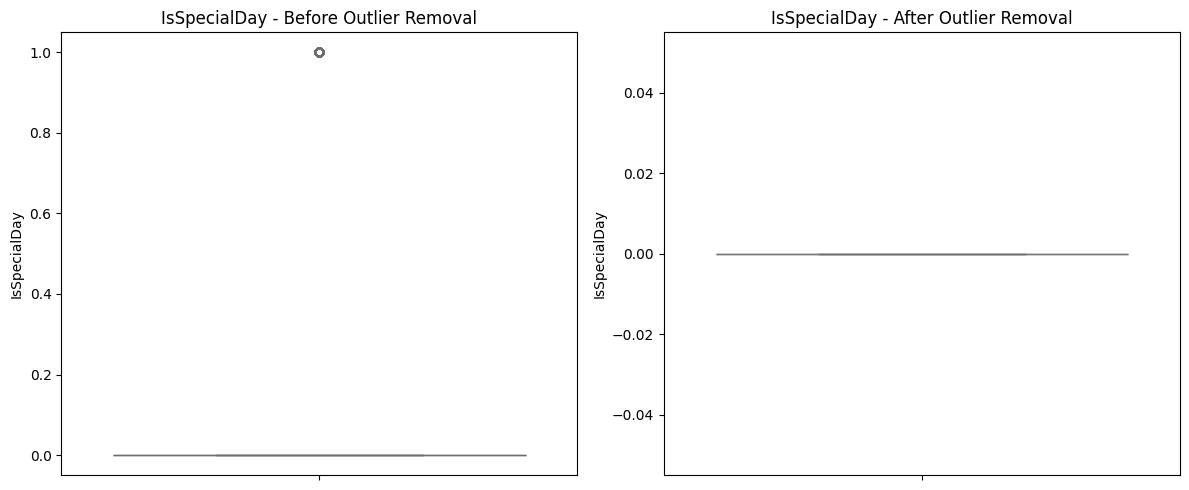

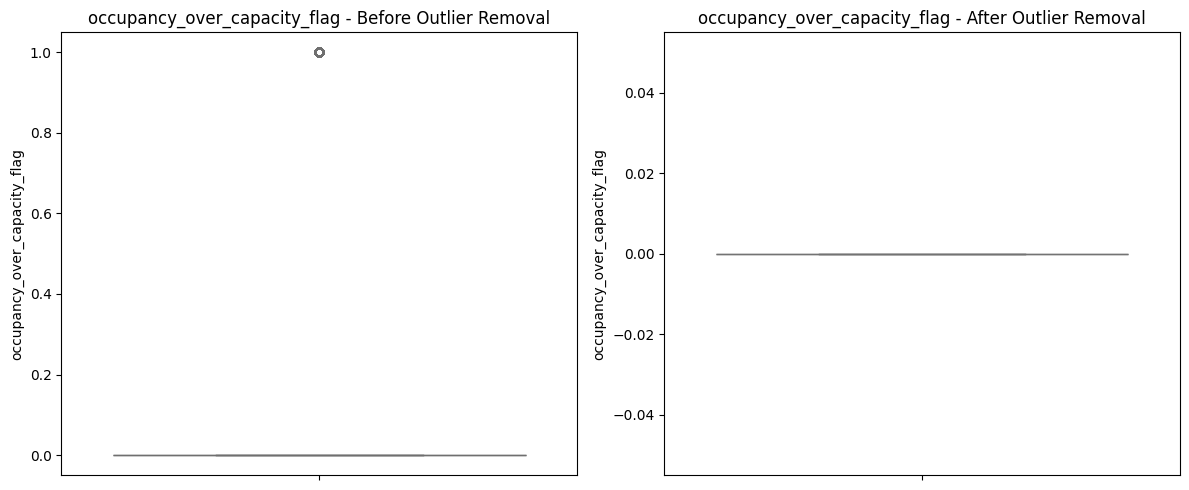

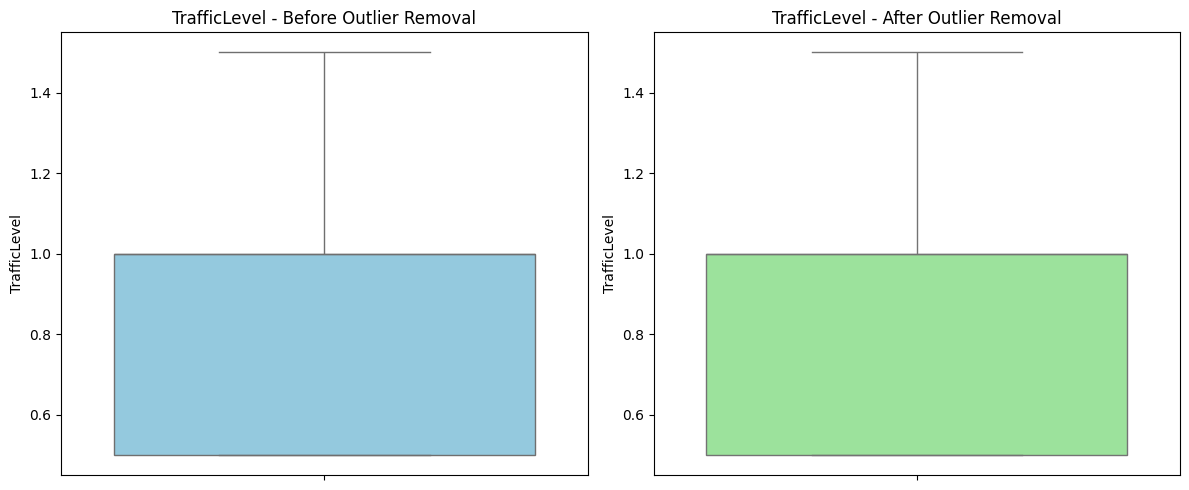

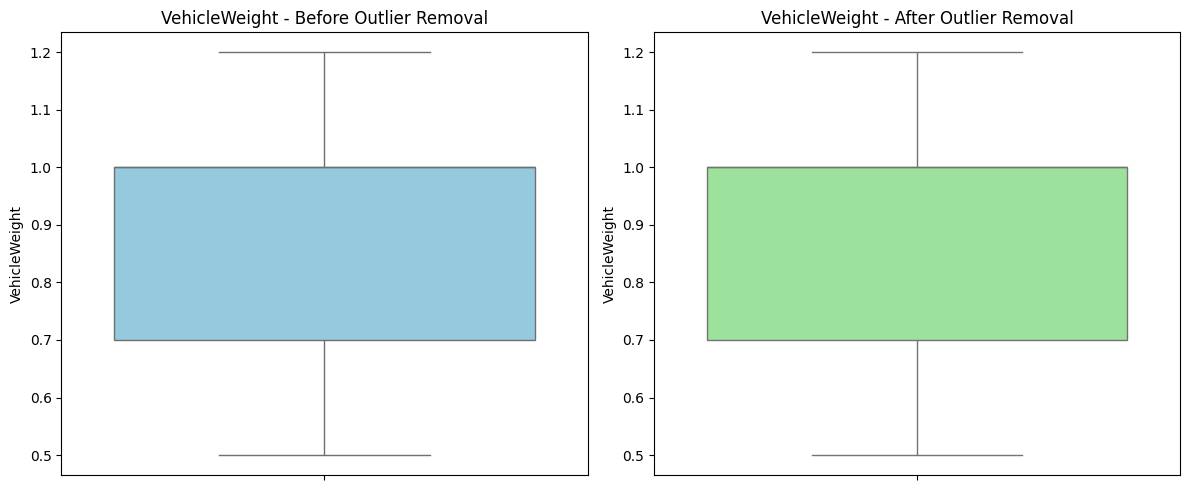

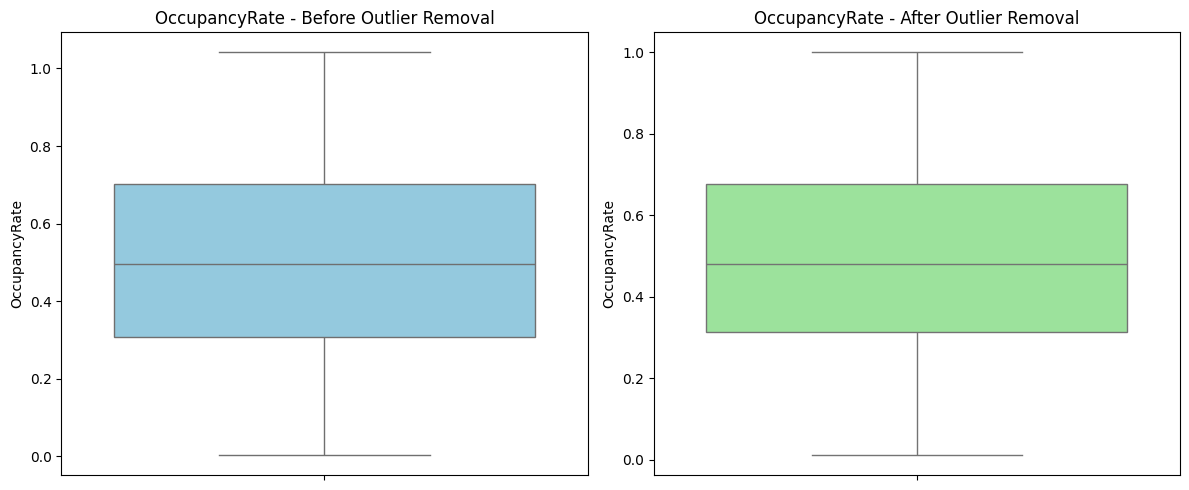

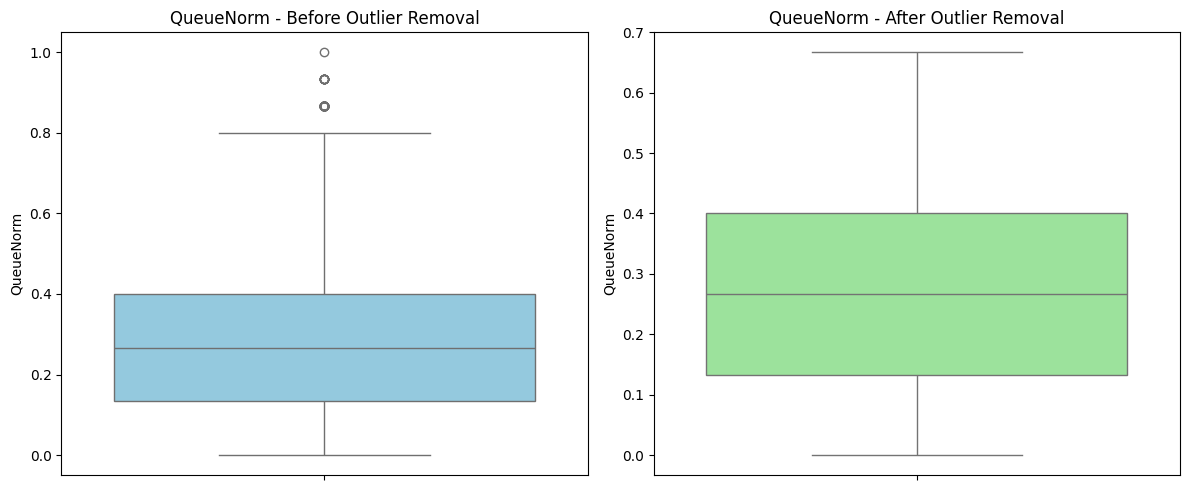

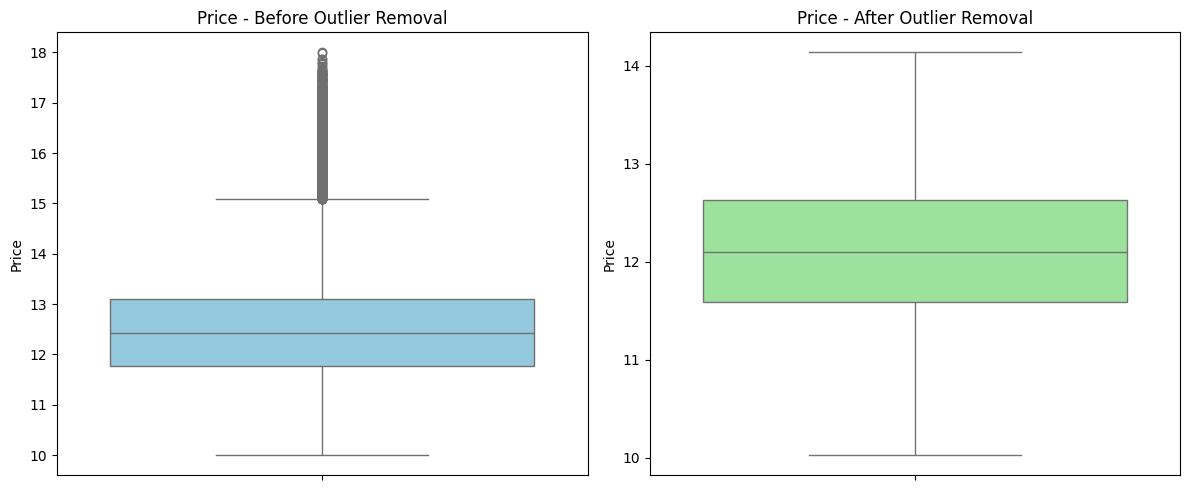

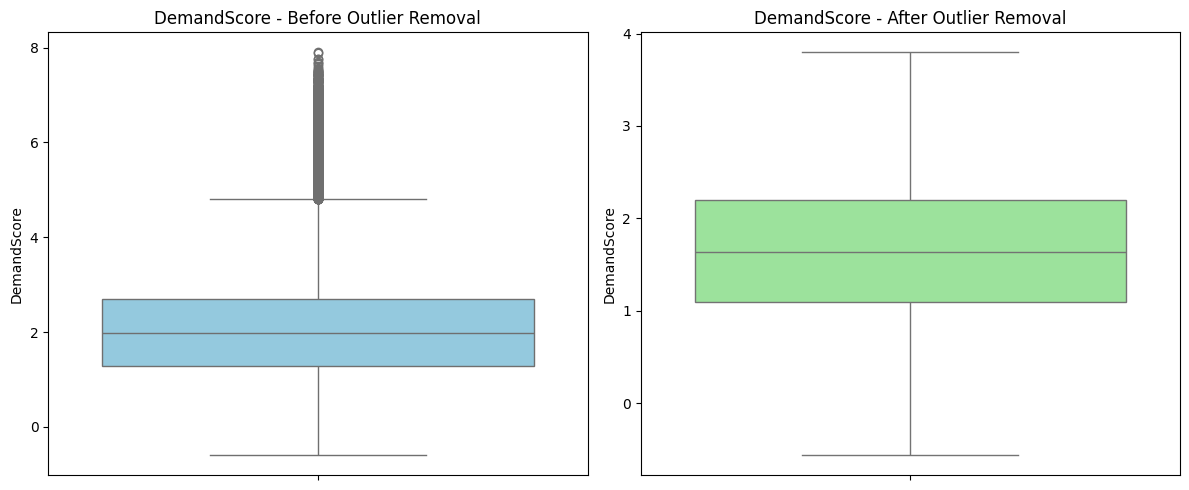

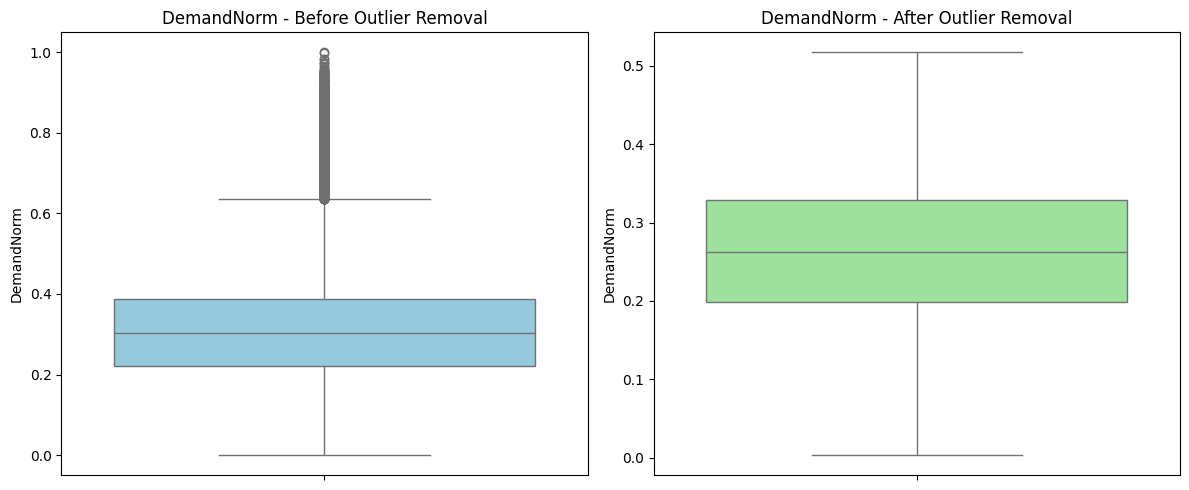

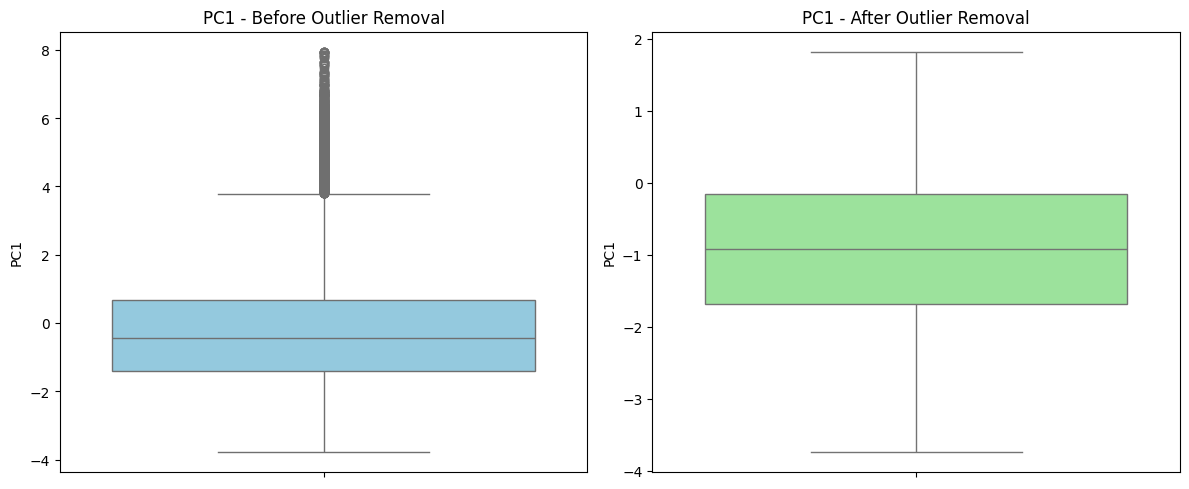

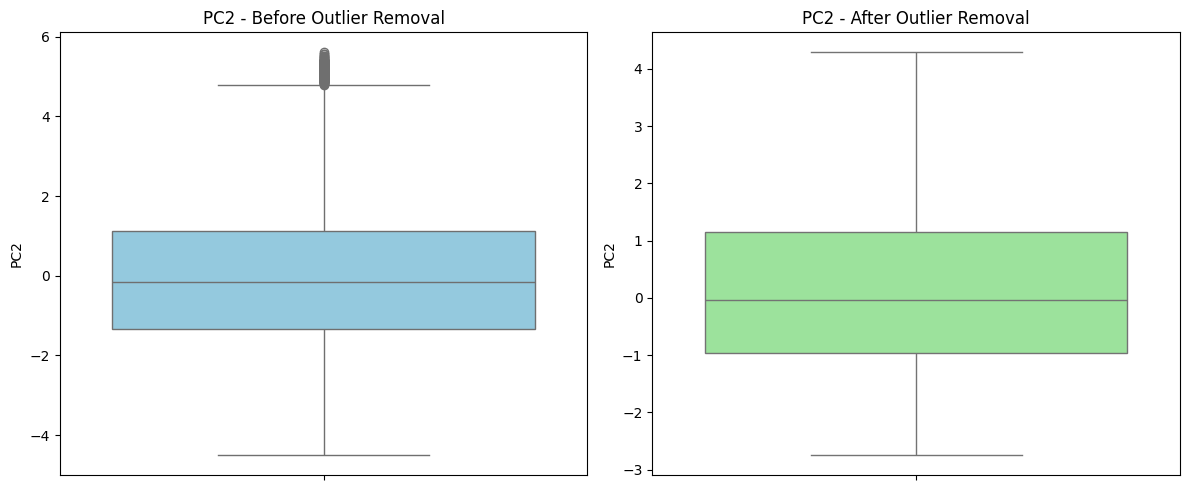

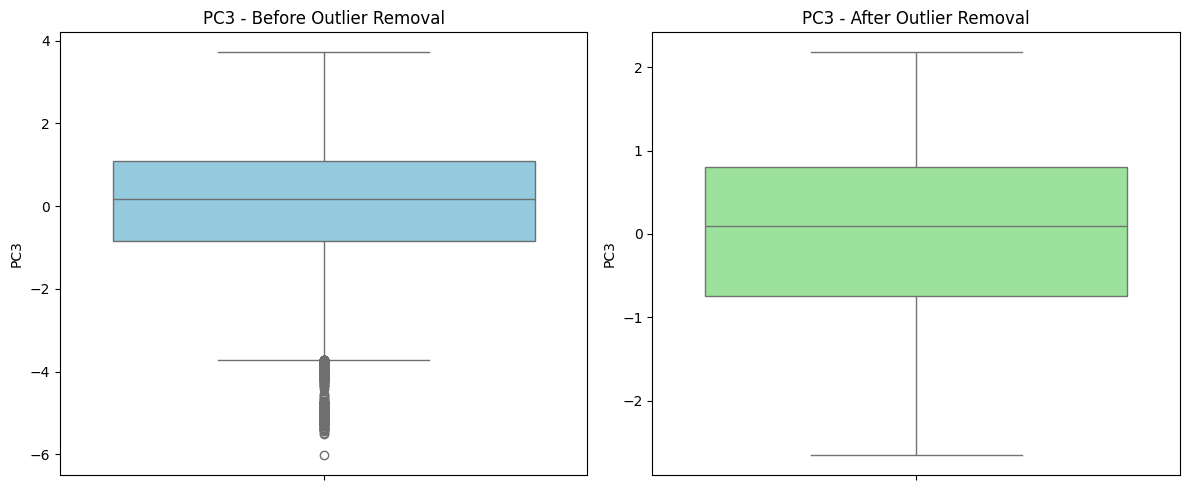

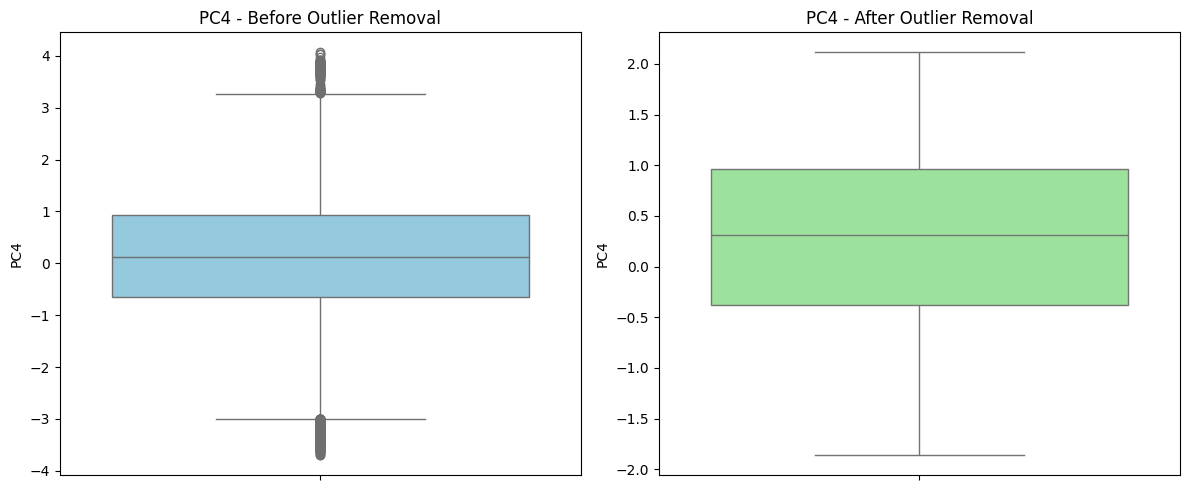

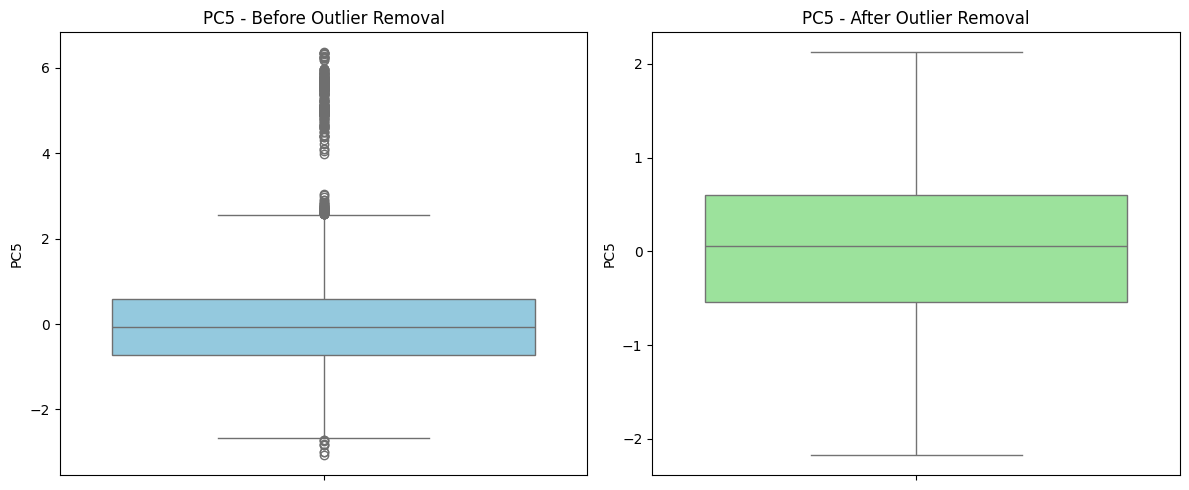

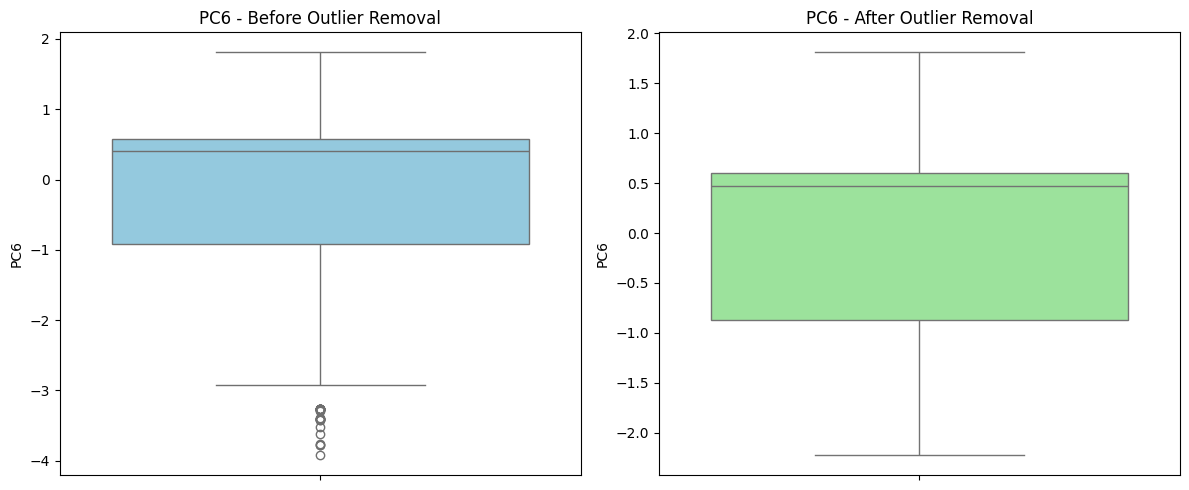

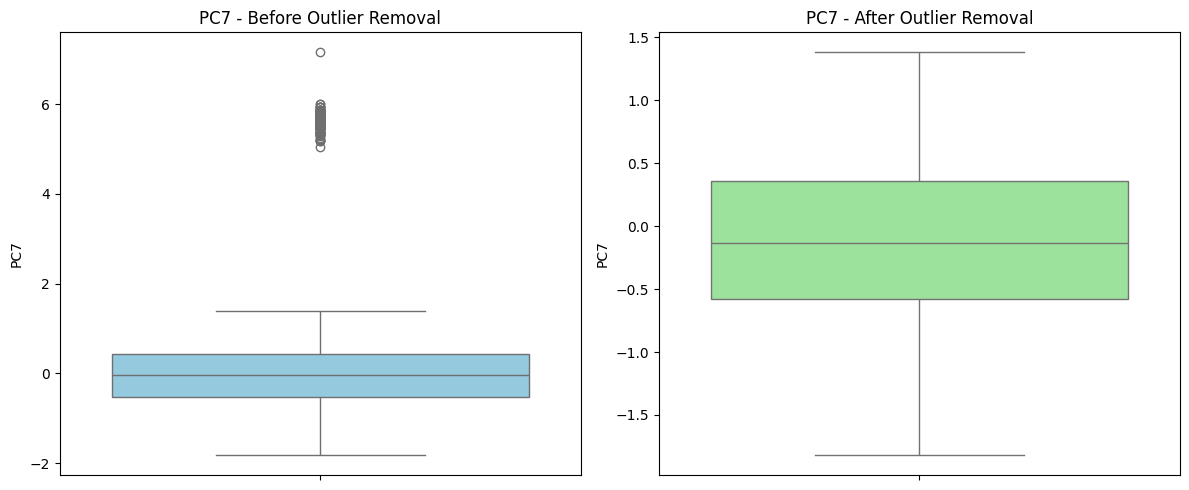

In [72]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

print("Numeric Columns:", num_cols)

# Function to remove outliers using IQR
def remove_outliers_iqr(data, cols):
    cleaned_df = data.copy()
    for col in cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before = cleaned_df.shape[0]
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
        after = cleaned_df.shape[0]

        print(f"{col}: Removed {before - after} outliers")
    return cleaned_df


df_clean = remove_outliers_iqr(df, num_cols)

print("\nOriginal shape:", df.shape)
print("Cleaned shape:", df_clean.shape)

def plot_boxplots(original_df, cleaned_df, cols):
    for col in cols:
        plt.figure(figsize=(12, 5))

        # Before cleaning
        plt.subplot(1, 2, 1)
        sns.boxplot(y=original_df[col], color="skyblue")
        plt.title(f"{col} - Before Outlier Removal")

        # After cleaning
        plt.subplot(1, 2, 2)
        sns.boxplot(y=cleaned_df[col], color="lightgreen")
        plt.title(f"{col} - After Outlier Removal")

        plt.tight_layout()
        plt.show()

# Call the function
plot_boxplots(df, df_clean, num_cols)

In [51]:
traffic_map = {'low': 0, 'average': 1, 'high': 2}
df['TrafficLevel'] = df['TrafficConditionNearby'].map(traffic_map)

In [52]:
vehicle_type_weights = {
    'cycle': 0.3,
    'bike': 0.5,
    'car': 1.0,   
    'truck': 1.5
}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_type_weights)

In [53]:
df['TrafficLevel'] = df['TrafficLevel'].fillna(1) 
df['VehicleWeight'] = df['VehicleWeight'].fillna(1.0) 

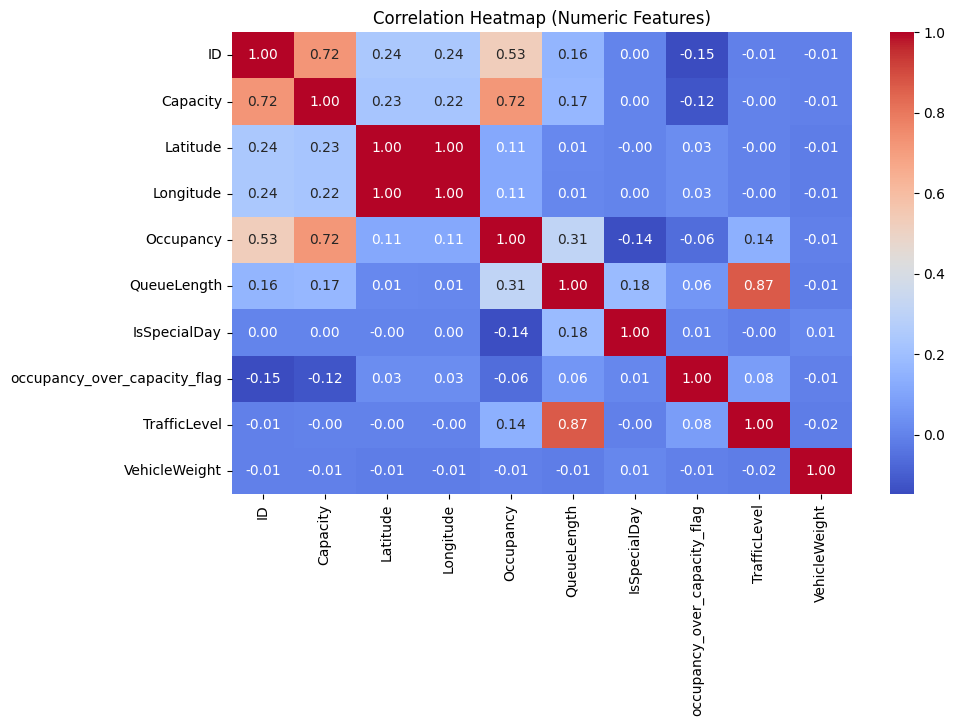

In [54]:

#understanding of relationship among features

#Correlation 
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()




<Axes: xlabel='Capacity', ylabel='Occupancy'>

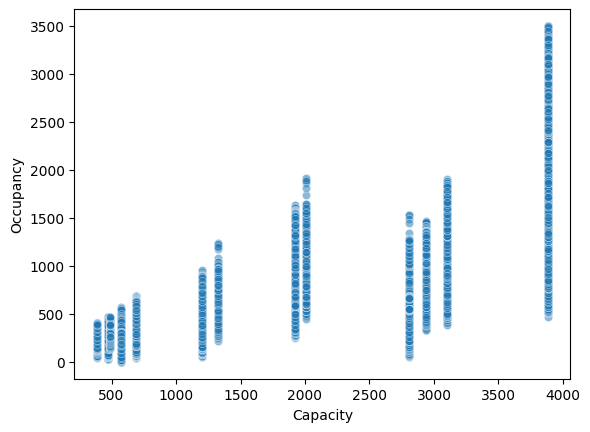

In [55]:
#Capacity vs Occupancy

sns.scatterplot(data=df, x="Capacity", y="Occupancy", alpha=0.5)


<Axes: xlabel='Occupancy', ylabel='QueueLength'>

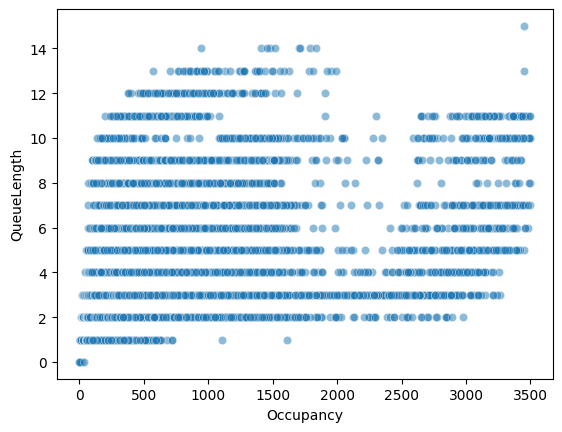

In [56]:
#Occupancy vs QueueLength
sns.scatterplot(data=df, x="Occupancy", y="QueueLength", alpha=0.5)


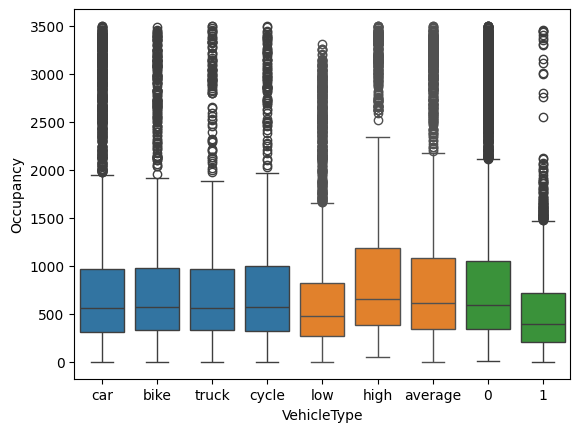

In [57]:
#Time of Day vs Occupancy
cat_cols = ["VehicleType", "TrafficConditionNearby", "IsSpecialDay"]
for c in cat_cols:
    sns.boxplot(data=df, x=c, y="Occupancy")


<Axes: xlabel='Hour', ylabel='Occupancy'>

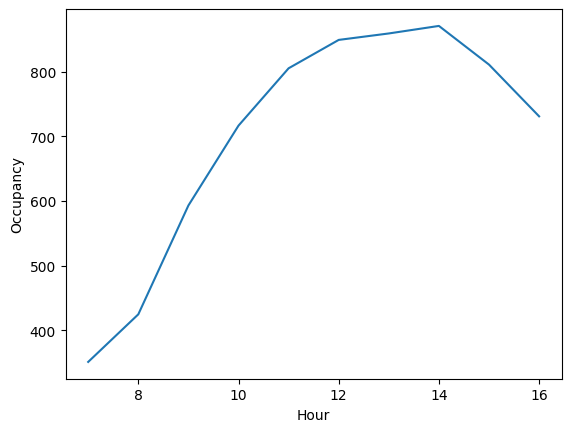

In [58]:
    # hour vs Occupancy
df["Hour"] = df["LastUpdatedTimestamp"].dt.hour
sns.lineplot(data=df, x="Hour", y="Occupancy", errorbar=None)



In [59]:
#feature construction
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']

max_queue = df['QueueLength'].max()
df['QueueNorm'] = df['QueueLength'] / max_queue

df.head(10)

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,LastUpdatedTimestamp,occupancy_over_capacity_flag,TrafficLevel,VehicleWeight,Hour,OccupancyRate,QueueNorm
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0,0,1.0,7,0.105719,0.066667
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,0,0,1.0,8,0.110919,0.066667
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00,2016-10-04 08:59:00,0,0,1.0,8,0.138648,0.133333
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00,2016-10-04 09:32:00,0,0,1.0,9,0.185442,0.133333
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00,2016-10-04 09:59:00,0,0,0.5,9,0.259965,0.133333
5,5,BHMBCCMKT01,577,26.144536,91.736172,177,car,low,3,0,04-10-2016,10:26:00,2016-10-04 10:26:00,0,0,1.0,10,0.306759,0.200000
6,6,BHMBCCMKT01,577,26.144536,91.736172,219,truck,high,6,0,04-10-2016,10:59:00,2016-10-04 10:59:00,0,2,1.5,10,0.379549,0.400000
7,7,BHMBCCMKT01,577,26.144536,91.736172,247,car,average,5,0,04-10-2016,11:25:00,2016-10-04 11:25:00,0,1,1.0,11,0.428076,0.333333
8,8,BHMBCCMKT01,577,26.144536,91.736172,259,cycle,average,5,0,04-10-2016,11:59:00,2016-10-04 11:59:00,0,1,0.3,11,0.448873,0.333333
9,9,BHMBCCMKT01,577,26.144536,91.736172,266,bike,high,8,0,04-10-2016,12:29:00,2016-10-04 12:29:00,0,2,0.5,12,0.461005,0.533333


In [60]:
df_model = df[['SystemCodeNumber', 'LastUpdatedTimestamp', 'OccupancyRate', 'QueueNorm','TrafficLevel', 'IsSpecialDay', 'VehicleWeight']]
df_model.head()

,SystemCodeNumber,LastUpdatedTimestamp,OccupancyRate,QueueNorm,TrafficLevel,IsSpecialDay,VehicleWeight
0,BHMBCCMKT01,2016-10-04 07:59:00,0.105719,0.066667,0,0,1.0
1,BHMBCCMKT01,2016-10-04 08:25:00,0.110919,0.066667,0,0,1.0
2,BHMBCCMKT01,2016-10-04 08:59:00,0.138648,0.133333,0,0,1.0
3,BHMBCCMKT01,2016-10-04 09:32:00,0.185442,0.133333,0,0,1.0
4,BHMBCCMKT01,2016-10-04 09:59:00,0.259965,0.133333,0,0,0.5


In [61]:
#Baseline Linear Pricing Model

base_price = 10  # Set base price as in later cells
alpha = 3.0      # Use the same alpha as in later cells

df = df.sort_values(by=['SystemCodeNumber', 'LastUpdatedTimestamp'])

df['Price'] = base_price
df['Price'] = df['Price'].astype(float)

df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
for lot in df['SystemCodeNumber'].unique():
    lot_data = df[df['SystemCodeNumber'] == lot].copy()
    for i in range(1, len(lot_data)):
        prev_price = lot_data.iloc[i-1]['Price']
        occupancy_rate = lot_data.iloc[i]['OccupancyRate']

        new_price = prev_price + alpha * (occupancy_rate - 0.5)
        new_price = max(5, min(new_price, 30))
        df.loc[lot_data.index[i], 'Price'] = new_price

df[['SystemCodeNumber', 'LastUpdatedTimestamp', 'Occupancy', 'Capacity', 'Price']].head(100)

,SystemCodeNumber,LastUpdatedTimestamp,Occupancy,Capacity,Price
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,10.000000
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,8.832756
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,8.915945
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,9.056326
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,9.279896
...,...,...,...,...,...
95,BHMBCCMKT01,2016-10-09 10:30:00,64,577,8.832756
96,BHMBCCMKT01,2016-10-09 11:04:00,100,577,9.019931
97,BHMBCCMKT01,2016-10-09 11:30:00,126,577,9.155113
98,BHMBCCMKT01,2016-10-09 11:57:00,148,577,9.269497


In [62]:
base_price = 10
lambda_ = 0.8 
traffic_mapping = {'low': 0.5, 'average': 1.0, 'high': 1.5}
df['TrafficLevel'] = df['TrafficConditionNearby'].map(traffic_mapping).fillna(1.0)
vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.2, 'cycle': 0.5}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights).fillna(1.0)
max_queue = df['QueueLength'].max()
df['QueueNorm'] = df['QueueLength'] / max_queue
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
alpha = 3.0    # weight for occupancy rate
beta = 2.0     # weight for queue length
gamma = 1.5    # weight for traffic congestion (subtracted)
delta = 4.0    # weight for special day effect
epsilon = 1.0  # weight for vehicle type

# Calculate demand score for each record
df['DemandScore'] = (alpha * df['OccupancyRate'] +
                     beta * df['QueueNorm'] -
                     gamma * df['TrafficLevel'] +
                     delta * df['IsSpecialDay'] +
                     epsilon * df['VehicleWeight'])

# Normalize demand scores to 0-1 range for stable price scaling
demand_min = df['DemandScore'].min()
demand_max = df['DemandScore'].max()
df['DemandNorm'] = (df['DemandScore'] - demand_min) / (demand_max - demand_min)

# Initialize Price column with base price
df['Price'] = base_price
df['Price'] = df['Price'].astype(float)

# Iterate over each parking lot to update prices based on demand
for lot in df['SystemCodeNumber'].unique():
    lot_data = df[df['SystemCodeNumber'] == lot].copy()
    
    # For each time step, calculate new price bounded between 0.5x and 2x base price
    for i in range(len(lot_data)):
        demand = lot_data.iloc[i]['DemandNorm']
        new_price = base_price * (1 + lambda_ * demand)
        new_price = max(base_price * 0.5, min(new_price, base_price * 2.0))
        df.loc[lot_data.index[i], 'Price'] = new_price


df[['SystemCodeNumber', 'LastUpdatedTimestamp', 'Occupancy', 'QueueLength', 'TrafficConditionNearby',
    'IsSpecialDay', 'VehicleType', 'Price']].head(20)


,SystemCodeNumber,LastUpdatedTimestamp,Occupancy,QueueLength,TrafficConditionNearby,IsSpecialDay,VehicleType,Price
0,BHMBCCMKT01,2016-10-04 07:59:00,61,1,low,0,car,11.219162
1,BHMBCCMKT01,2016-10-04 08:25:00,64,1,low,0,car,11.233854
2,BHMBCCMKT01,2016-10-04 08:59:00,80,2,low,0,car,11.437796
3,BHMBCCMKT01,2016-10-04 09:32:00,107,2,low,0,car,11.570020
4,BHMBCCMKT01,2016-10-04 09:59:00,150,2,low,0,bike,11.498031
5,BHMBCCMKT01,2016-10-04 10:26:00,177,3,low,0,car,12.038412
6,BHMBCCMKT01,2016-10-04 10:59:00,219,6,high,0,truck,11.396387
7,BHMBCCMKT01,2016-10-04 11:25:00,247,5,average,0,car,11.925966
8,BHMBCCMKT01,2016-10-04 11:59:00,259,5,average,0,cycle,11.513784
9,BHMBCCMKT01,2016-10-04 12:29:00,266,8,high,0,bike,11.406780


In [63]:


#feature selection
vt = VarianceThreshold(threshold=0.0)
numeric_df = df.select_dtypes(include=['number']).fillna(0)
vt.fit(numeric_df)


feature_candidates = [col for col in numeric_df.columns if col != 'Price']

X = df[feature_candidates].fillna(0)
y = df['Price'].fillna(0)


mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores (higher = stronger relationship with Price):")
print(mi_series)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nRandom Forest Feature Importances:")
print(importances)


Mutual Information Scores (higher = stronger relationship with Price):
DemandScore                     8.529861
DemandNorm                      8.529739
OccupancyRate                   1.874717
Occupancy                       0.718092
ID                              0.429382
IsSpecialDay                    0.421939
Capacity                        0.391075
Longitude                       0.177819
Latitude                        0.165280
QueueLength                     0.141759
QueueNorm                       0.141637
Hour                            0.091229
VehicleWeight                   0.056646
TrafficLevel                    0.052076
occupancy_over_capacity_flag    0.029248
dtype: float64

Random Forest Feature Importances:
DemandScore                     5.131504e-01
DemandNorm                      4.868476e-01
Occupancy                       4.467808e-07
OccupancyRate                   2.939870e-07
ID                              2.688100e-07
QueueNorm                       2.1221

In [64]:
#hypothesis testing


# t-test special day vs non-special day (Price)
price_special = df[df['IsSpecialDay']==1]['Price']
price_non = df[df['IsSpecialDay']==0]['Price']
tstat, pval = ttest_ind(price_special.dropna(), price_non.dropna(), equal_var=False)
print('tstat, pval', tstat, pval)

# ANOVA for VehicleType
groups = [g['Price'].dropna().values for _,g in df.groupby('VehicleType') if len(g)>2]
if len(groups) > 1:
    fstat, pval = f_oneway(*groups)
    print('ANOVA', fstat, pval)

# Pearson correlation
r, p = pearsonr(df['OccupancyRate'].fillna(0), df['Price'].fillna(0))
print('pearson r,p', r, p)


tstat, pval 234.52760979592156 0.0
ANOVA 124.94300010080529 4.0934060847467795e-80
pearson r,p 0.21541730923330818 8.65079464834735e-192


In [65]:
#PCA for dimensionality reduction


numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()


scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])


pca = PCA(n_components=0.95)  
pca_data = pca.fit_transform(scaled_data)


explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)
print("Number of components selected:", pca.n_components_)


pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca_data, columns=pca_columns)


df = pd.concat([df, df_pca], axis=1)


df_pca.head()

Explained Variance Ratio: [0.27143313 0.2112642  0.16565253 0.11081731 0.08299418 0.06624264
 0.05376766]
Number of components selected: 7


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-2.558789,-2.505558,0.241388,1.109633,-0.803428,0.587985,0.313351
1,-2.541226,-2.505582,0.239319,1.106504,-0.786419,0.586937,0.302349
2,-2.151580,-2.197154,0.084518,1.159339,-0.804255,0.595021,0.247272
3,-1.993460,-2.197841,0.065403,1.131634,-0.651190,0.585635,0.148068
4,-2.119397,-2.083966,-0.108253,1.151578,-0.594322,-0.920928,-0.204752


In [66]:
#Proximity Measures



features = ['OccupancyRate', 'QueueNorm', 'TrafficLevel', 'VehicleWeight']
data = df[features].fillna(0)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Calculate Euclidean Distance
euclidean_dist = euclidean_distances(data_scaled)
print("Euclidean Distance Matrix:\n", euclidean_dist)

# Calculate Cosine Similarity
cosine_sim = cosine_similarity(data_scaled)
print("Cosine Similarity Matrix:\n", cosine_sim)



Euclidean Distance Matrix:
 [[0.         0.0211237  0.41003694 ... 3.73194768 2.39731134 2.10342874]
 [0.0211237  0.         0.40363907 ... 3.71725826 2.37646801 2.08267041]
 [0.41003694 0.40363907 0.         ... 3.57753919 2.2319869  1.9336256 ]
 ...
 [3.73194768 3.71725826 3.57753919 ... 0.         2.60163836 2.64531661]
 [2.39731134 2.37646801 2.2319869  ... 2.60163836 0.         0.2983613 ]
 [2.10342874 2.08267041 1.9336256  ... 2.64531661 0.2983613  0.        ]]
Cosine Similarity Matrix:
 [[ 1.          0.99997914  0.99220908 ... -0.0975165   0.36011428
   0.51375875]
 [ 0.99997914  1.          0.99186773 ... -0.09486378  0.3660584
   0.51919745]
 [ 0.99220908  0.99186773  1.         ... -0.13088235  0.32819333
   0.48563579]
 ...
 [-0.0975165  -0.09486378 -0.13088235 ...  1.          0.32554199
   0.27745296]
 [ 0.36011428  0.3660584   0.32819333 ...  0.32554199  1.
   0.98512438]
 [ 0.51375875  0.51919745  0.48563579 ...  0.27745296  0.98512438
   1.        ]]


In [67]:

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
df['Cluster'] = clusters
print(df[['SystemCodeNumber', 'Cluster']])

      SystemCodeNumber  Cluster
0          BHMBCCMKT01        1
1          BHMBCCMKT01        1
2          BHMBCCMKT01        1
3          BHMBCCMKT01        1
4          BHMBCCMKT01        2
...                ...      ...
18363         Shopping        0
18364         Shopping        1
18365         Shopping        2
18366         Shopping        1
18367         Shopping        1

[18368 rows x 2 columns]


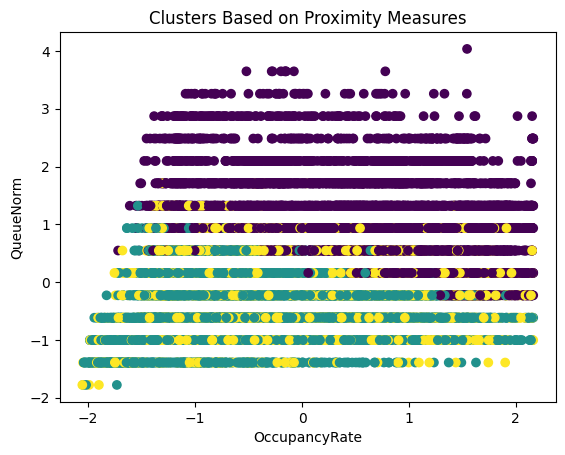

In [68]:
# Visualize clusters
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters, cmap='viridis')
plt.xlabel('OccupancyRate')
plt.ylabel('QueueNorm')
plt.title('Clusters Based on Proximity Measures')
plt.show()

In [69]:
# Final curated dataset
curated_cols = [
    'SystemCodeNumber', 'LastUpdatedTimestamp', 'OccupancyRate', 'QueueNorm',
    'TrafficLevel', 'VehicleWeight', 'DemandScore', 'DemandNorm', 'Price', 'Cluster'
]
existing_cols = [col for col in curated_cols if col in df.columns]
df_curated = df[existing_cols]
df_curated.to_csv('curated_dataset.csv', index=False)
print("Curated dataset saved as 'curated_dataset.csv'")
print("Curated dataset shape:", df_curated.shape)
print(df_curated.head(10))

Curated dataset saved as 'curated_dataset.csv'
Curated dataset shape: (18368, 10)
  SystemCodeNumber LastUpdatedTimestamp  OccupancyRate  QueueNorm  \
0      BHMBCCMKT01  2016-10-04 07:59:00       0.105719   0.066667   
1      BHMBCCMKT01  2016-10-04 08:25:00       0.110919   0.066667   
2      BHMBCCMKT01  2016-10-04 08:59:00       0.138648   0.133333   
3      BHMBCCMKT01  2016-10-04 09:32:00       0.185442   0.133333   
4      BHMBCCMKT01  2016-10-04 09:59:00       0.259965   0.133333   
5      BHMBCCMKT01  2016-10-04 10:26:00       0.306759   0.200000   
6      BHMBCCMKT01  2016-10-04 10:59:00       0.379549   0.400000   
7      BHMBCCMKT01  2016-10-04 11:25:00       0.428076   0.333333   
8      BHMBCCMKT01  2016-10-04 11:59:00       0.448873   0.333333   
9      BHMBCCMKT01  2016-10-04 12:29:00       0.461005   0.533333   

   TrafficLevel  VehicleWeight  DemandScore  DemandNorm      Price  Cluster  
0           0.5            1.0     0.700491    0.152395  11.219162        1  
1 